# HATESPEECH DETECTION AND MODERATION 
An increase of digital adoption due to “jio Effect” in the Indian market  and also due to recent covid made digital participation  of indians on social media more active .which results in online content continues to grow, so does the spread of hate speech .


# Objective
The objective of the project is to develop a model that can recognize hate speech in a textual data.
The main objectives of the project are listed below:
1) detect the hate speech hiding in plain sight.
2) classify the hate speech .


# Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import itertools as it
import pickle
import os
from  pathlib import Path

import nltk
from nltk.corpus import stopwords                  # module for stop words that come with NLTK
from nltk.stem.wordnet import WordNetLemmatizer    # module for lemmatization
from nltk import word_tokenize, pos_tag            # tokenization and Part of Speech tagging

nltk.download('stopwords')                         #stopwords used to preprocess the corpus
stopwords_english = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


# Dataset Description
1) The dataset used in this project has been taken from the Andrii Samoshyn Database and wikipedia comment  who has public license for this dataset . <br>
2) The dataset has been split into training data and testing data. <br>
3) unique texts classified into 6 labels such 'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate' .<br>
4) its a raw data which contains links ,userid ,emojis, … <br>
5) https://hatespeechdata.com/   its a public maintained data library  on github.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hatespeechdata/test_labels.csv
/kaggle/input/hatespeechdata/train_data.csv
/kaggle/input/hatespeechdata/train.csv
/kaggle/input/hatespeechdata/test.csv


In [3]:
stopwords_english = stopwords.words('english')
train_data = pd.read_csv("../input/hatespeechdata/train.csv")
test_data = pd.read_csv('../input/hatespeechdata/test.csv')
test_label_data = pd.read_csv('../input/hatespeechdata/test_labels.csv')
 

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
 train_data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:

for i in range(10):
    print(train_data['comment_text'][i])
    print('---------------')

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
---------------
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
---------------
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
---------------
"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any prefere

In [8]:

test_data.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [9]:

test_label_data = test_label_data.loc[test_label_data['toxic']!=-1]

In [10]:

test_label_data.iloc[:,1:-1].sum(axis=0) / test_label_data.shape[0]

toxic           0.095189
severe_toxic    0.005736
obscene         0.057692
threat          0.003298
insult          0.053565
dtype: float64

In [11]:


test = test_label_data.merge(test_data, on='id', how="inner")
test.head(10)


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,0,0,0,0,0,0,:Dear god this site is horrible.
2,0002f87b16116a7f,0,0,0,0,0,0,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,0,0,0,0,0,0,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,0,0,0,0,0,0,""" \n\n == Before adding a new product to the l..."
5,000663aff0fffc80,0,0,0,0,0,0,this other one from 1897
6,000689dd34e20979,0,0,0,0,0,0,== Reason for banning throwing == \n\n This ar...
7,000844b52dee5f3f,0,0,0,0,0,0,|blocked]] from editing Wikipedia. |
8,00091c35fa9d0465,1,0,0,0,0,0,"== Arabs are committing genocide in Iraq, but ..."
9,000968ce11f5ee34,0,0,0,0,0,0,Please stop. If you continue to vandalize Wiki...


# Cleaning the texts/Comments

In [12]:
#preprocesses a text

def preprocess(corpus):
    
    '''
    From a string, make text lowercase, remove hyperlinks, punctuation, word containing numbers, stopwords.
    Input : a list of strings
    Output : a list of tokens stored in a generator (yield)
    '''

    for text in corpus:

        text = text.lower()                                               # Lowercase
        text = re.sub(r'https?://[^\s\n\r]+', '', text)                   # Remove links
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)   # Remove punctuation
        text = re.sub('\w*\d\w*', '', text)                               # Remove words containing numbers
    
        yield ' '.join([word for word in text.split(' ') if word not in stopwords_english]) # Return a generator 


In [13]:
%%time

clean_comments = list(preprocess(train_data['comment_text']))

CPU times: user 38.6 s, sys: 68.2 ms, total: 38.7 s
Wall time: 38.7 s


In [14]:

for i in range(10):
    print(clean_comments[i])
    print('------------')



explanation
why edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired 
------------
daww matches background colour im seemingly stuck thanks  talk  january   utc
------------
hey man im really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info
------------

more
i cant make real suggestions improvement  wondered section statistics later subsection types accidents  think references may need tidying exact format ie date format etc later noone else first  preferences formatting style references want please let know

there appears backlog articles review guess may delay reviewer turns listed relevant form eg wikipediagoodarticlenominationstransport  
------------
sir hero chance remember page thats
------------


congratulations well use tools well  · talk 
------------
cocksucker piss around work
-----------

In [15]:
%%time
# for the test set
test_clean_comments = list(preprocess(test["comment_text"]))

CPU times: user 15.2 s, sys: 27.4 ms, total: 15.2 s
Wall time: 15.2 s


# Feature Generation / Word Embeddings

1) BOW (Bag of words) --> BOW method calculates the frequency of a word for each document, based on a Vocabulary.

In [16]:
%%time

# Bag-of-words
vectorizer = CountVectorizer(min_df=3,max_df=0.9) #Filter words that are note present at least in min_df documents & no more that 90% of all documents
bow = vectorizer.fit_transform(clean_comments) #return a document-term matrix (n_samples,n_features)
bow_test = vectorizer.transform(test_clean_comments) # We do the same for test set, we just transform to have the same number of words

CPU times: user 10.4 s, sys: 157 ms, total: 10.6 s
Wall time: 10.6 s


In [17]:
bow.shape , bow_test.shape

((159571, 52731), (63978, 52731))

In [18]:
# Let's take a look at the features / vocabulary
print(vectorizer.get_feature_names_out()[:30])
print('------------')
print(vectorizer.get_feature_names_out()[100:130])
print('------------')
print(vectorizer.get_feature_names_out()[1000:1030])
print('------------')
print(vectorizer.get_feature_names_out()[10000:10030])

['aa' 'aaa' 'aaand' 'aac' 'aachen' 'aah' 'aaliyah' 'aamir' 'aan' 'aand'
 'aang' 'aap' 'aaps' 'aar' 'aardvark' 'aarem' 'aaron' 'aarons' 'aas'
 'aatalk' 'aau' 'aave' 'ab' 'aba' 'aback' 'abad' 'abaddon' 'abandon'
 'abandoned' 'abandoning']
------------
['abolish' 'abolished' 'abolishing' 'abolition' 'abolitionist'
 'abolitionists' 'abomb' 'abominable' 'abomination' 'abominations'
 'aboriginal' 'aboriginals' 'aborigine' 'aborigines' 'abort' 'aborted'
 'abortion' 'abortions' 'abot' 'abotu' 'abou' 'aboumekhael' 'abound'
 'abounds' 'abour' 'about' 'aboutcom' 'abouth' 'abouti' 'above']
------------
['agreement' 'agreements' 'agrees' 'agress' 'agressing' 'agression'
 'agressive' 'agressively' 'agressor' 'agricultural' 'agriculture'
 'agriculturists' 'agrizoophobia' 'aground' 'ags' 'aguilera' 'aguri' 'agw'
 'ah' 'aha' 'ahaha' 'ahahahahaha' 'aharon' 'ahd' 'ahead' 'ahem' 'ahh'
 'ahhh' 'ahhhh' 'ahhrelief']
------------
['copright' 'coproduced' 'coproducer' 'cops' 'coptic' 'copts' 'copula'
 'copulat

2) TFIDF(term frequency Inverse Document frequency) --> its a measure of originality of a word by comparing number of times a word occurs in a document with the number of documents word appears in .

In [19]:
# Word embeddings
tfidf_vec = TfidfVectorizer(min_df=1,max_df=0.9)
tfidf = tfidf_vec.fit_transform(clean_comments)
tfidf_test = tfidf_vec.transform(test_clean_comments)
print(tfidf_vec.get_feature_names_out()[:30])

['aa' 'aaa' 'aaaa' 'aaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany'
 'aaaaaaaaaah' 'aaaaaaaaaahhhhhhhhhhhhhh'
 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh'
 'aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh' 'aaaaaaw' 'aaaaah' 'aaaaai' 'aaaaaups'
 'aaaah' 'aaaannnnyyyywwwwhhhheeeerrrreeee' 'aaaaso' 'aaaawwww' 'aaages'
 'aaaghh' 'aaah' 'aaahhh' 'aaahs' 'aaai' 'aaajade' 'aaand' 'aaarated'
 'aaarrrgggh' 'aaaww' 'aaba' 'aabove']


# Models
****Train & Test preparation****

In [20]:
# Let's define target labels
target = train_data[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
# target = np.array(target) #transform dataframe into array
target.head()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [21]:
target.sum(axis=0) / target.shape[0]

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

In [22]:
keys = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
test[keys].sum(axis=0) /test.shape[0]

toxic            0.095189
severe_toxic     0.005736
obscene          0.057692
threat           0.003298
insult           0.053565
identity_hate    0.011129
dtype: float64

# Validating Model 

Train and validate the model

Naive Bayes model Without maximum likelyhood 

In [23]:
nb_accuracy = {}
for i,j in enumerate(target.columns):
   
    nb = MultinomialNB()

    cv_score = np.mean(cross_val_score(nb, tfidf_test,
                                       test[j], cv=3, scoring='roc_auc'))
    nb_accuracy[j] = cv_score
    print(cv_score)
nb_accuracy['mdl_accuracy'] = np.mean(list(nb_accuracy.values()))
print('CV score using Naive Bayes - {}'.format(np.mean(list(nb_accuracy.values()))))
nb_accuracy = pd.Series(nb_accuracy)

0.826196564897189
0.7158978069566581
0.8218051327921571
0.7340558157644601
0.809764046584916
0.7838186446360561
CV score using Naive Bayes - 0.7819230019385727


NB-Logistic Regression model 

In [24]:
def probNB(bow,target,cat):

    '''
    Naive Bayes probability for each word
    Inputs :
    bow : bag of words (with doc in rows and words in columns)
    target : classification vector (filled with 1 and 0)
    cat : 1 or 0, in target
    Output : 
    Vector of Naive Bayes probabilities with smoothing (n_words,1)
    '''

    p = np.array(bow[target==cat].sum(axis=0))

    return np.transpose((p+1) / (p.sum() + bow.shape[1]))

In [25]:
def get_model(bow,target):

    '''
    Function that return the log likelihood of a document
    Inputs :
    bow : bag of words (n_doc,n_words)
    target : classification of comments (n_doc,1)
    Output : 
    Return a vector of Log Likelihood for each comment (Naïve Bayes) (n_doc,1)
    '''

    log = np.log(probNB(bow,target,1)/probNB(bow,target,0))
    m = bow.dot(log)
    model = LogisticRegression().fit(m,target)
    return model , log

In [26]:
df_classification = pd.DataFrame() #We store probabilities into a Dataframe
df_classification['Comments'] = test['comment_text']
classification = pd.Series(index=['identity_hate','insult','obscene','severe_toxic','threat','toxic'],dtype=int)
nb_log_accuracy = {}
for i,j in enumerate(target.columns):
    print('fit', j)
    model,log = get_model(tfidf,target[j])
   
    df_classification[j] = model.predict(tfidf_test.dot(log))
    
    cv_score = np.mean(cross_val_score(model, tfidf_test.dot(log),
                                       test[j], cv=3, scoring='roc_auc'))
    nb_log_accuracy[j] = cv_score
    print(cv_score)
    nb_log_accuracy['mdl_accuracy'] = np.mean(list(nb_log_accuracy.values()))


#     score = model.score(tfidf_test.dot(log) ,test[j])
#     print(f"Accuracy : {score:.4}")
#     print('----')   
print('CV score using Naive Bayes - {}'.format(np.mean(list(nb_log_accuracy.values()))))
nb_log_accuracy = pd.Series(nb_log_accuracy)


fit toxic
0.8841105986555999
fit severe_toxic
0.8117292729349739
fit obscene
0.8735658682632993
fit threat
0.7822930649113515
fit insult
0.8569351816491234
fit identity_hate
0.8182679639339181
CV score using Naive Bayes - 0.8378970640325882


# Compare

In [27]:
class Utility:

    

    @staticmethod
    def compare_models(md1_acc, md1_name, md2_acc, md2_name, title=None):
      

        md1_acc = md1_acc.mul(100, axis=0)
        md2_acc = md2_acc.mul(100, axis=0)
        df = pd.DataFrame(md1_acc, columns=[md1_name])
        df[md2_name] = md2_acc
        my_plot = df.plot(kind='bar', figsize=(12, 10),
                          legend=True, grid=True, title=title, stacked=False)
        my_plot.set_xlabel("Classes")
        my_plot.set_ylabel("Accuracy")
        return my_plot

<AxesSubplot:title={'center':'Naive Bayes vs NB Logistic Regression'}, xlabel='Classes', ylabel='Accuracy'>

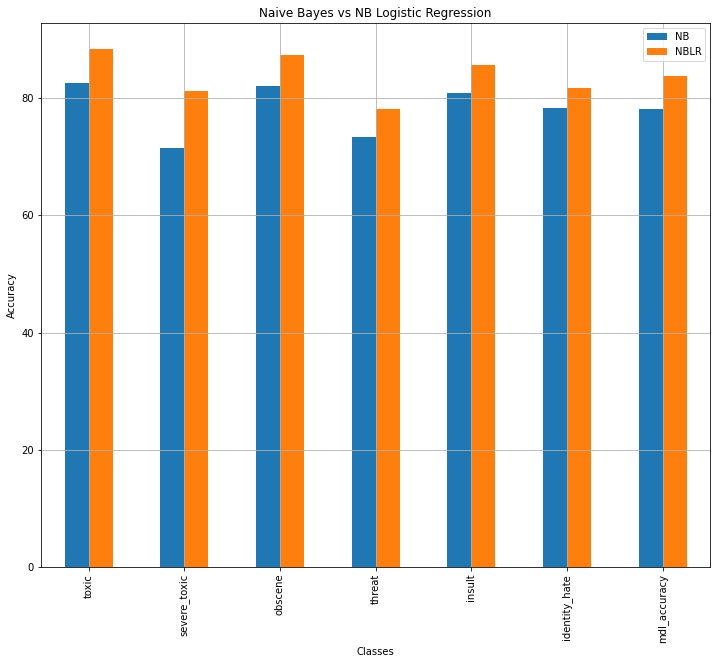

In [28]:
Utility.compare_models(md1_acc=nb_accuracy,md1_name="NB", md2_acc=nb_log_accuracy, md2_name="NBLR",title="Naive Bayes vs NB Logistic Regression")

# Deployment

In [29]:
if 1==1:

    # TFIDF vectorizer
    pickle.dump(tfidf_vec,open('tfidf_vectorizer.pkl','wb'))

    # Logistic regression models + Log Likelihood based on Naïve Bayes for each toxicity classification
    for i,j in enumerate(target.columns):
        print('fit', j)
        model,log = get_model(tfidf,target[j])
        pickle.dump(model,open('models_'+f'{target.columns[i]}.pkl','wb'))
        pickle.dump(log,open('logs_'+f'{target.columns[i]}.pkl','wb'))
        #Save models and logs as tuples

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate
